# Banking Fraud with MLOps

# ML operations pipeline

### Overview

This is the final piece of the Banking Fraud puzzle.

The below will create a pipeline to deploy the endpoints, keep them up to date and supply metrics which are monitored in Cloudwatch.

This is based upon the excellent example

https://github.com/aws-samples/amazon-sagemaker-safe-deployment-pipeline

This notebook will add on additional steps in order to use the information we have in the best way forward and also applying automation, seecurity and monitoring  to our models and endpoints.

We can of course still use a manual method to update our endpoints but that would be silly! :)

The steps we will be following are shown below:

![Code pipeline](img/code_pipeline.png)

Following a series of steps to trigger demo

1. [Setup](#Setup)
2. [Data preparation](#Data-Preparation)
   1. [Splitting and standardising](#Splitting-and-standardising)
3. [Start the build](#Start-Build)
4. [Wait for training job](#Wait-for-Training-Job)
5. [Test dev deployment](#Test-Dev-Deployment)
6. [Approve prod endpoint](#Approve-Prod-Deployment)
7. [Test prod deployment](#Test-Prod-Deployment)
   1. [Test Rest API](#Test-rest-api)
8.  [CloudWatch monitoring](#CloudWatch-Monitoring)

## Setup

Rather than adding to the previous notebook, we will start again.

First, we import AWS specific modules and specify S3 data location

In [1]:
# import sys
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install --upgrade seaborn
# !{sys.executable} -m pip install --upgrade imbalanced-learn
import boto3
import os
from random import seed, sample
import sagemaker
import sagemaker.amazon.amazon_estimator
from sagemaker import get_execution_role
from sagemaker.serializers import CSVSerializer

Import python ML modules

In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()
sns.set_context("paper")

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
# from xgboost.sklearn import XGBClassifier

In [3]:
bucket = 'sagemaker-pmelvin'
prefix = 'compile_xgb_v3'
hp_prefix = 'hp_tuning_v3'

csv_data = 'input-data/bb_banking_fraud.csv'
csv_removed_types = 'input-data/removed-specific-types/01a89090-e9b6-4b07-8a49-b0244d6dc035.csv'
full_data_location = 's3://{}/{}'.format(bucket, csv_data)
clean_data_location = 's3://{}/{}'.format(bucket, csv_removed_types)

#local_file = 'bb_banking_fraud.csv'

role = get_execution_role()
sess = sagemaker.Session()
smclient = boto3.Session().client('sagemaker')

## Data preparation

Now we reload the data

In [4]:
!aws s3 cp 's3://sagemaker-pmelvin/input-data/bb_banking_fraud.csv' 'bb_banking_fraud.csv'

download: s3://sagemaker-pmelvin/input-data/bb_banking_fraud.csv to ./bb_banking_fraud.csv


In [5]:
%%time
# df_full = pd.read_csv(full_data_location)
df_full = pd.read_csv('bb_banking_fraud.csv')

CPU times: user 7.6 s, sys: 1.13 s, total: 8.73 s
Wall time: 8.73 s


In [6]:
# %%time
# df_clean = pd.read_csv(clean_data_location)

Change the feature nates and move the **isFraud** column to the front

In [7]:
df_u = df_full.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', 'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest', 'isfraud':'isFraud'})

In [8]:
df_u_copy = df_u.copy()

df_u['hourOfDay'] = np.nan
df_u.hourOfDay = df_u_copy.step % 24

In [9]:
first_col = df_u.pop('isFraud')
df_u.insert(0, 'isFraud', first_col)

In [10]:
df_u.head()

,isFraud,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,hourOfDay
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,1
1,0,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,1
2,1,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,0,1
3,1,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,0,1
4,0,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,1


In [11]:
sample = df_u.sample(n=10000, random_state=42)

Now that we have the updated dataset and the sample we must use the **RandomUnderSampler** to add more datapoints within the datset (just as before)

In [12]:
def get_features(df):
    
    selected_cols = [
        'type', 'amount', 'oldBalanceOrig', 'newBalanceOrig',
        'oldBalanceDest', 'newBalanceDest', 'isFraud', 'hourOfDay'
    ]
    
    df = df[selected_cols].copy()
    dummies = pd.get_dummies(df.type)
    df = pd.concat([df, dummies], axis=1).drop("type", axis=1)
    
    return df

In [13]:
def reduce_data(pca_df):
    pca_df = pca_df.copy()
    target = pca_df.pop("isFraud")
    scaler = StandardScaler()
    pca_df = scaler.fit_transform(pca_df)
    pca = PCA(n_components=2)
    components = pca.fit_transform(pca_df)

    comp_df = pd.DataFrame(components, columns=["X", "y"])
    target = target.reset_index(drop=True)
    plot_df = pd.concat([comp_df, target], axis=1)
    
    return plot_df

In [14]:
def fraud_plot(plot_df, maj_alpha=0.5, min_alpha=1, save=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.scatterplot(x="X", y="y", alpha=maj_alpha, data=plot_df[plot_df.isFraud == 0], label="Legitimate")
    sns.scatterplot(x="X", y="y", alpha=min_alpha, data=plot_df[plot_df.isFraud == 1], ax=ax, label="Fraud")
    plt.title("Legitimate vs Fraudulent Purchases")
    plt.tight_layout()
    if save != None:
        plt.savefig(save)
    plt.show()
    
    pass

In [15]:
# processed_data = get_features(sample)
# plot_df = reduce_data(processed_data)
# fraud_plot(plot_df)

In [16]:
# processed_data.shape

In [17]:
# processed_data.head(n=5)

In [18]:
from imblearn.under_sampling import RandomUnderSampler
RUS = RandomUnderSampler(sampling_strategy={0: 9589}, random_state=42)

In [19]:
def resample(df, method):
    processed_df = get_features(df)
    target = processed_df.pop('isFraud')

    processed_x, processed_y = method.fit_resample(processed_df, target)

    cols = list(processed_df.columns) + ["isFraud"]

    pdf_x = pd.DataFrame(processed_x, columns=processed_df.columns)
    pdf_y = pd.DataFrame(processed_y, columns=['isFraud'])
    resampled_df = pd.concat([pdf_x, pdf_y], axis=1)
    
    return resampled_df

Let's just check out data, looking first at the shape and then a nice plot

In [20]:
%%time
rus_resampled = resample(df_u, RUS)
print(rus_resampled.shape)
print(rus_resampled.isFraud.value_counts())

(17802, 12)
0    9589
1    8213
Name: isFraud, dtype: int64
CPU times: user 2.43 s, sys: 940 ms, total: 3.37 s
Wall time: 3.36 s


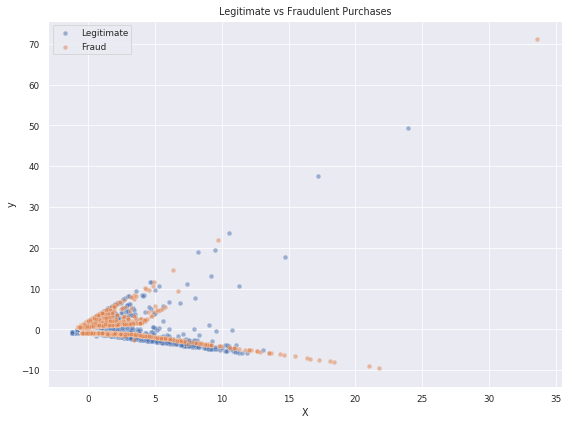

In [21]:
fraud_plot(reduce_data(rus_resampled), min_alpha=0.5)

In [22]:
# from imblearn.over_sampling import SMOTE
# SM = SMOTE(random_state=42)

In [23]:
# %%time
# sm_resampled = resample(df_u, SM)
# print(sm_resampled.shape)
# print(sm_resampled.isFraud.value_counts())

In [24]:
# sm_sample = sm_resampled.sample(n=10000, random_state=42)
# fraud_plot(reduce_data(sm_sample), min_alpha=0.5)


## Splitting and standardising

In [25]:
first_col = rus_resampled.pop('isFraud')
rus_resampled.insert(0, 'isFraud', first_col)

In [26]:
rus_resampled.shape

(17802, 12)

In [27]:
rus_resampled.head()

,isFraud,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,hourOfDay,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,183806.32,19391.00,0.00,382572.19,566378.51,18,0,1,0,0,0
1,0,521.37,0.00,0.00,0.00,0.00,17,0,0,0,1,0
2,0,3478.18,19853.00,16374.82,0.00,0.00,11,0,0,0,1,0
3,0,1716.05,5769.17,4053.13,0.00,0.00,19,0,0,0,1,0
4,0,253129.93,1328499.49,1581629.42,2713220.48,2460090.55,18,1,0,0,0,0


In [28]:
X = rus_resampled.drop('isFraud', 1)
y = rus_resampled.isFraud

We will split the dataset with a 80% for training, 15% for validation and 5% for testing data

In [29]:
train_ratio = 0.80
validation_ratio = 0.15
test_ratio = 0.05

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state=42, shuffle=True, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42, shuffle=True, stratify=y) 

print('split train: {}, val: {}, test: {} '.format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

split train: 14241, val: 2670, test: 891 


We now specify the MinMaxScaler and apply it to the split datasets

In [30]:
scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = StandardScaler()

scaler.fit(X_train)

MinMaxScaler()

In [31]:
#
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)
X_test  = pd.DataFrame(scaler.fit_transform(X_test),columns = X_test.columns)
X_val   = pd.DataFrame(scaler.fit_transform(X_val),columns = X_val.columns)

In [32]:
#
# A copy is made of the dataframe to use later, as we need to convert them into numpy arrrays
X_train_ins = X_train.copy()
X_test_ins  = X_test.copy()
X_val_ins   = X_val.copy()

X_train_ins.insert(0, 'isFraud', y_train.values)
X_test_ins.insert(0, 'isFraud', y_test.values)
X_val_ins.insert(0, 'isFraud', y_val.values)

In [33]:
#
X_train.to_csv('train.csv', index=False, header=False)
X_val.to_csv('validation.csv', index=False, header=False)

# Save test and baseline with headers
X_test.to_csv('test.csv', index=False, header=True)
X_train.to_csv('baseline.csv', index=False, header=True)

In [34]:
#
# convert to numpy arrays for later use
X_train = X_train.to_numpy()
X_test  = X_test.to_numpy()
X_val   = X_val.to_numpy()

Upload the csv files to S3

In [35]:
# Get the session and default bucket
session = sagemaker.session.Session()
bucket = session.default_bucket()

bb_prefix = 'blackbelt/v1'

s3_train_uri = sess.upload_data('train.csv', bucket, bb_prefix + '/data/training')
print('Uploaded training data location: {}'.format(s3_train_uri))

s3_val_uri = sess.upload_data('validation.csv', bucket, bb_prefix + '/data/validation')
print('Uploaded validation data location: {}'.format(s3_val_uri))

s3_baseline_uri = sess.upload_data('baseline.csv', bucket, bb_prefix + '/data/baseline')
print('Uploaded validation data location: {}'.format(s3_baseline_uri))

s3_output_location = 's3://{}/{}/output'.format(bucket, bb_prefix)
print('Training artifacts will be uploaded to: {}'.format(s3_output_location))

Uploaded training data location: s3://sagemaker-us-east-1-880038709331/blackbelt/v1/data/training/train.csv
Uploaded validation data location: s3://sagemaker-us-east-1-880038709331/blackbelt/v1/data/validation/validation.csv
Uploaded validation data location: s3://sagemaker-us-east-1-880038709331/blackbelt/v1/data/baseline/baseline.csv
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-880038709331/blackbelt/v1/output


## Start the build

The pipeline source has two inputs:

- A Git source repository containing the model definition and all supporting infrastructure
- A S3 data source that includes a reference to the training and validation datasets
 
First, we load variables from environment

In [36]:
from botocore.exceptions import ClientError
import time

region = boto3.Session().region_name
artifact_bucket = os.environ['ARTIFACT_BUCKET']
pipeline_name = os.environ['PIPELINE_NAME']
model_name = os.environ['MODEL_NAME']

print('region: {}'.format(region))
print('artifact bucket: {}'.format(artifact_bucket))
print('pipeline: {}'.format(pipeline_name))
print('model name: {}'.format(model_name))

region: us-east-1
artifact bucket: mlops-bb-proj-artifact-us-east-1-880038709331
pipeline: bb-proj
model name: bb-proj


We upload a data source meta data to trigger a new build

In [37]:
from io import BytesIO
import zipfile
import json

input_data = {
    'TrainingUri': s3_train_uri,
    'ValidationUri': s3_val_uri,
    'BaselineUri': s3_baseline_uri
}

hyperparameters = {
    'num_round': 20
}

data_source_key = '{}/data-source.zip'.format(pipeline_name)

zip_buffer = BytesIO()
with zipfile.ZipFile(zip_buffer, 'a') as zf:
    zf.writestr('inputData.json', json.dumps(input_data))
    zf.writestr('hyperparameters.json', json.dumps(hyperparameters))
zip_buffer.seek(0)

s3 = boto3.client('s3')
s3.put_object(Bucket=artifact_bucket, Key=data_source_key, Body=bytearray(zip_buffer.read()))

{'ResponseMetadata': {'RequestId': 'FED9D3EC69847A75',
  'HostId': 'j+1s3wefLgU2MEraLAelkTG6z4/pzxskyBzRveAo/eiW7/Mgx9TEl4Fe87mluKu1uk7PJ04Gq2A=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'j+1s3wefLgU2MEraLAelkTG6z4/pzxskyBzRveAo/eiW7/Mgx9TEl4Fe87mluKu1uk7PJ04Gq2A=',
   'x-amz-request-id': 'FED9D3EC69847A75',
   'date': 'Tue, 12 Jan 2021 11:06:00 GMT',
   'x-amz-version-id': 'bU1bww46Jm_l53MnuaSee3CVXrceK.nU',
   'etag': '"1f67b854522f8972de61d7ae094d63a8"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"1f67b854522f8972de61d7ae094d63a8"',
 'VersionId': 'bU1bww46Jm_l53MnuaSee3CVXrceK.nU'}

## Wait for training Job

Follow the code pipeline to wait until the training job is complete

In [38]:
from IPython.core.display import HTML

HTML('<a target="_blank" href="https://{0}.console.aws.amazon.com/codesuite/codepipeline/pipelines/{1}/view?region={0}">Code Pipeline</a>'.format(region, pipeline_name))

Once the training and baseline job is complete we can inspect the exeriment metrics.

In [39]:
from sagemaker import analytics
model_analytics = analytics.ExperimentAnalytics(experiment_name=model_name)
analytics_df = model_analytics.dataframe()

if (analytics_df.shape[0] == 0):
    raise(Exception('Please wait.  No training or baseline jobs'))

pd.set_option('display.max_colwidth', 100) # Increase column width to show full copmontent name
cols = ['TrialComponentName', 'DisplayName', 'SageMaker.InstanceType', 
        'train:rmse - Last', 'validation:rmse - Last'] # return the last rmse for training and validation
analytics_df[analytics_df.columns & cols].head(2)

,TrialComponentName,DisplayName,SageMaker.InstanceType
0,mlops-bb-proj-pbl-574feb46-1fa0-400f-9ce8-b0d9d71d8e22-aws-processing-job,Baseline,ml.m5.xlarge
1,mlops-bb-proj-574feb46-1fa0-400f-9ce8-b0d9d71d8e22-aws-training-job,Training,ml.m4.xlarge


## Test dev deployment

Once the endpoint has been deployed and awaiting approval, we can begin some tests.

In [40]:
codepipeline = boto3.client('codepipeline')

def get_pipeline_stage(pipeline_name, stage_name):
    response = codepipeline.get_pipeline_state(name=pipeline_name)
    for stage in response['stageStates']:
        if stage['stageName'] == stage_name:
            return stage
        
# Get last execution id
deploy_dev = get_pipeline_stage(pipeline_name, 'DeployDev')
if not 'latestExecution' in deploy_dev:
    raise(Exception('Please wait.  Deploy dev not started'))
    
execution_id = deploy_dev['latestExecution']['pipelineExecutionId']
dev_endpoint_name = 'mlops-{}-dev-{}'.format(model_name, execution_id)

print('endpoint name: {}'.format(dev_endpoint_name))

endpoint name: mlops-bb-proj-dev-574feb46-1fa0-400f-9ce8-b0d9d71d8e22


In [41]:
from tqdm import tqdm

try:
    # Support SageMaker v2 SDK: https://sagemaker.readthedocs.io/en/stable/v2.html
    from sagemaker.predictor import Predictor
    from sagemaker.serializers import CSVSerializer
    def get_predictor(endpoint_name):
        xgb_predictor = Predictor(endpoint_name)
        xgb_predictor.serializer = CSVSerializer()
        return xgb_predictor
except:
    # Fallback to SageMaker v1.70 SDK
    from sagemaker.predictor import RealTimePredictor, csv_serializer
    def get_predictor(endpoint_name):
        xgb_predictor = RealTimePredictor(endpoint_name)
        xgb_predictor.content_type = 'text/csv'
        xgb_predictor.serializer = csv_serializer
        return xgb_predictor

def predict(predictor, data, rows=500):
    split_array = np.array_split(data, round(data.shape[0] / float(rows)))
    predictions = ''
    for array in tqdm(split_array):
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

We use the predictor with our datasets to have a further look at

In [42]:
dev_predictor = get_predictor(dev_endpoint_name)
predictions = predict(dev_predictor, X_test[:, 1:])

100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


In [43]:
binary_predictions = np.where(predictions > 0.5, 1, 0)

In [44]:
y_train_preds = predict(dev_predictor, X_train[:, 1:])

100%|██████████| 28/28 [00:00<00:00, 30.65it/s]


In [45]:
y_valid_preds = predict(dev_predictor, X_val[:, 1:])

100%|██████████| 5/5 [00:00<00:00, 31.22it/s]


In [46]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)

    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [47]:
thresh = 0.1

# print('XGBoost Classifier')
print('Training:')
xgb_train_auc, xgb_train_accuracy, xgb_train_recall, xgb_train_precision, xgb_train_specificity = print_report(y_train, y_train_preds, thresh)

print('Validation:')
xgb_valid_auc, xgb_valid_accuracy, xgb_valid_recall, xgb_valid_precision, xgb_valid_specificity = print_report(y_val, y_valid_preds, thresh)

Training:
AUC:0.767
accuracy:0.683
recall:0.332
precision:0.939
specificity:0.982
 
Validation:
AUC:0.752
accuracy:0.688
recall:0.388
precision:0.884
specificity:0.955
 


## Approve prod deployment

If we are happy with this metric, we can go ahead and approve with the widget below, or manually in the CodePipeline  by clicking the "Review" button.

![Deploy Dev](img/deploy_dev.png)

In [ ]:
import ipywidgets as widgets

def on_click(obj):
    result = { 'summary': approval_text.value, 'status': obj.description }
    response = codepipeline.put_approval_result(
      pipelineName=pipeline_name,
      stageName='DeployDev',
      actionName='ApproveDeploy',
      result=result,
      token=approval_action['token']
    )
    button_box.close()
    print(result)
    
# Create the widget if we are ready for approval
deploy_dev = get_pipeline_stage(pipeline_name, 'DeployDev')
if not 'latestExecution' in deploy_dev['actionStates'][-1]:
    raise(Exception('Please wait.  Deploy dev not complete'))

approval_action = deploy_dev['actionStates'][-1]['latestExecution']
if approval_action['status'] == 'Succeeded':
    print('Dev approved: {}'.format(approval_action['summary']))
elif 'token' in approval_action:
    approval_text = widgets.Text(placeholder='Optional approval message')   
    approve_btn = widgets.Button(description="Approved", button_style='success', icon='check')
    reject_btn = widgets.Button(description="Rejected", button_style='danger', icon='close')
    approve_btn.on_click(on_click)
    reject_btn.on_click(on_click)
    button_box = widgets.HBox([approval_text, approve_btn, reject_btn])
    display(button_box)
else:
    raise(Exception('Please wait.  No dev approval'))

## Test prod deployment

The prod deployment will start shortly after approval.

Production deployment is managed through a CloudFormation stack which performs the following:

1. Creates SageMaker Endpoint with Data Capture and AutoScaling enabled
2. Creates Model Monitoring Schedule with CloudWatch Alarm
3. Deploys an API Gateway Lambda with AWS Code Deploy

![Cloud Formation](img/cloud_formation.png)

List the last events and how long ago they occurred.

In [48]:
from datetime import datetime, timedelta
from dateutil.tz import tzlocal

def get_event_dataframe(events):
    stack_cols = ['LogicalResourceId', 'ResourceStatus', 'ResourceStatusReason', 'Timestamp']
    stack_event_df = pd.DataFrame(events)[stack_cols].fillna('')
    stack_event_df['TimeAgo'] = (datetime.now(tzlocal())-stack_event_df['Timestamp'])
    return stack_event_df.drop('Timestamp', axis=1)

cfn = boto3.client('cloudformation')

stack_name = stack_name='{}-deploy-prd'.format(pipeline_name)
print('stack name: {}'.format(stack_name))

# Get latest stack events
while True:
    try:
        response = cfn.describe_stack_events(StackName=stack_name)
        break
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)
    
get_event_dataframe(response['StackEvents']).head()

stack name: bb-proj-deploy-prd


,LogicalResourceId,ResourceStatus,ResourceStatusReason,TimeAgo
0,bb-proj-deploy-prd,CREATE_COMPLETE,,00:01:26.213494
1,SagemakerScheduleAlarm,CREATE_COMPLETE,,00:01:28.661494
2,SagemakerScheduleAlarm,CREATE_IN_PROGRESS,Resource creation Initiated,00:01:28.964494
3,SagemakerScheduleAlarm,CREATE_IN_PROGRESS,,00:01:29.695494
4,SagemakerMonitoringSchedule,CREATE_COMPLETE,,00:01:32.206494


We can send some traffic to the production endpoint now

In [49]:
prd_endpoint_name='mlops-{}-prd-{}'.format(model_name, execution_id)
print('prod endpoint: {}'.format(prd_endpoint_name))

prod endpoint: mlops-bb-proj-prd-574feb46-1fa0-400f-9ce8-b0d9d71d8e22


We wait until the endpoint has finishing updated before we send some traffic

In [50]:
prd_predictor = get_predictor(prd_endpoint_name)
predictions = predict(prd_predictor, X_test[:, 1:])

100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


## Test Rest API

Get back the deployment progress and rest API endpoint

In [51]:
def get_stack_status(stack_name):
    response = cfn.describe_stacks(StackName=stack_name)
    if response['Stacks']:
        stack = response['Stacks'][0]
        outputs = None
        if 'Outputs' in stack:
            outputs = dict([(o['OutputKey'], o['OutputValue']) for o in stack['Outputs']])
        return stack['StackStatus'], outputs 

outputs = None
while True:
    try:
        status, outputs = get_stack_status(stack_name)
        response = smclient.describe_endpoint(EndpointName=prd_endpoint_name)
        print("Endpoint status: {}".format(response['EndpointStatus']))
        if outputs:
            break
        elif status.endswith('FAILED'):
            raise(Exception('Stack status: {}'.format(status)))
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)

if outputs:
    print('deployment application: {}'.format(outputs['DeploymentApplication']))
    print('rest api: {}'.format(outputs['RestApi']))

Endpoint status: InService
deployment application: bb-proj-deploy-prd-ServerlessDeploymentApplication-1FD3NJR0N49ZM
rest api: https://der5u9os3g.execute-api.us-east-1.amazonaws.com/Prod/api/


Check the deployment application to see if its created and started to shift traffic.

In [52]:
from IPython.core.display import HTML

In [53]:
HTML('<a target="_blank" href="https://{0}.console.aws.amazon.com/codesuite/codedeploy/applications/{1}?region={0}">Deployment Application</a>'.format(region, outputs['DeploymentApplication']))

## CloudWatch Monitoring

AWS [CloudWatch Synthetics](https://aws.amazon.com/blogs/aws/new-use-cloudwatch-synthetics-to-monitor-sites-api-endpoints-web-workflows-and-more/) provides allow you to setup a canary to test that your API is returning an expected value on a regular interval.  This is a great way to validate that the blue/green deployment is not causing any downtime for our end-users.

### Create Canary

Let's setup a "canary" to continously test the production API, and a dashboard to visualize the results.

In [61]:
from urllib.parse import urlparse
from string import Template
from io import BytesIO
import zipfile

# Format the canary_js with rest_api and payload
rest_url = urlparse(rest_api)

with open('canary.js') as f:
    canary_js = Template(f.read()).substitute(hostname=rest_url.netloc, path=rest_url.path, 
                                              data=payload.decode('utf-8').strip())
# Write the zip file
zip_buffer = BytesIO()
with zipfile.ZipFile(zip_buffer, 'w') as zf:
    zip_path = 'nodejs/node_modules/apiCanaryBlueprint.js' # Set a valid path
    zip_info = zipfile.ZipInfo(zip_path)
    zip_info.external_attr = 0o0755 << 16 # Ensure the file is readable
    zf.writestr(zip_info, canary_js)
zip_buffer.seek(0)

# Create the canary
synth = boto3.client('synthetics')

role = sagemaker.get_execution_role()
s3_canary_uri = 's3://{}/{}'.format(artifact_bucket, model_name)
canary_name = 'mlops_{}'.format(model_name)

response = synth.create_canary(
    Name=canary_name,
    Code={
        'ZipFile': bytearray(zip_buffer.read()),
        'Handler': 'apiCanaryBlueprint.handler'
    },
    ArtifactS3Location=s3_canary_uri,
    ExecutionRoleArn=role,
    Schedule={ 
        'Expression': 'rate(10 minutes)', 
        'DurationInSeconds': 0 },
    RunConfig={
        'TimeoutInSeconds': 60,
        'MemoryInMB': 960
    },
    SuccessRetentionPeriodInDays=31,
    FailureRetentionPeriodInDays=31,
    RuntimeVersion='syn-1.0',
)

print('Creating canary: {}'.format(canary_name))

Creating canary: mlops_bb-proj


Create the a CloudWatch alarm when success percent drops below 90% for that canary

In [62]:
cloudwatch = boto3.client('cloudwatch')

canary_alarm_name = '{}-synth-lt-threshold'.format(canary_name)

response = cloudwatch.put_metric_alarm(
    AlarmName=canary_alarm_name,
    ComparisonOperator='LessThanThreshold',
    EvaluationPeriods=1,
    DatapointsToAlarm=1,
    Period=600, # 10 minute interval
    Statistic='Average',
    Threshold=90.0,
    ActionsEnabled=False,
    AlarmDescription='SuccessPercent LessThanThreshold 90%',
    Namespace='CloudWatchSynthetics',
    MetricName='SuccessPercent',
    Dimensions=[
        {
          'Name': 'CanaryName',
          'Value': canary_name
        },
    ],
    Unit='Seconds'
)

print('Creating alarm: {}'.format(canary_alarm_name))

Creating alarm: mlops_bb-proj-synth-lt-threshold


Let's wait for the canary to be read, then start it and wait until running.  The

In [63]:
while True:
    try:
        response = synth.get_canary(Name=canary_name)
        status = response['Canary']['Status']['State']    
        print('Canary status: {}'.format(status))
        if status == 'ERROR':
            raise(Exception(response['Canary']['Status']['StateReason']))    
        elif status == 'READY':
            synth.start_canary(Name=canary_name)
        elif status == 'RUNNING':
            break        
    except ClientError as e:
        if e.response["Error"]["Code"] == "ResourceNotFoundException":
            print('No canary found.')
            break
        print(e.response["Error"]["Message"])
    time.sleep(10)

# Output a html link to the cloudwatch console
HTML('<a target="_blank" href="https://{0}.console.aws.amazon.com/cloudwatch/home?region={0}#synthetics:canary/detail/{1}">CloudWatch Canary</a>'.format(region, canary_name))

Canary status: READY
Canary status: RUNNING


### Create Dashboard

Finally let's create a AWS CloudWatch Dashboard to visualize the key performane metrics and alarms.

In [64]:
sts = boto3.client('sts')
account_id = sts.get_caller_identity().get('Account')
dashboard_name = 'mlops-{}'.format(model_name)

with open('dashboard.json') as f:
    dashboard_body = Template(f.read()).substitute(region=region, account_id=account_id, model_name=model_name)
    response = cloudwatch.put_dashboard(
        DashboardName=dashboard_name,
        DashboardBody=dashboard_body
    )

# Output a html link to the cloudwatch dashboard
HTML('<a target="_blank" href="https://{0}.console.aws.amazon.com/cloudwatch/home?region={0}#dashboards:name={1}">CloudWatch Dashboard</a>'.format(region, canary_name))

### Trigger Retraining

Our CodePipeline is configured with a [CloudWatch Events](https://docs.aws.amazon.com/codepipeline/latest/userguide/create-cloudtrail-S3-source.html) to start our pipeline for retraining when the drift detection metric alrams.

We can simulate drift by putting metric `0.5` which is above the threshold of `0.2`.  This will trigger the alarm, and start the code pipeline retraining.

Click through to the Alarm and CodePipeline with the links below.

In [66]:
deploy_prd = get_pipeline_stage(pipeline_name, 'DeployPrd')
if not 'latestExecution' in deploy_prd:
    raise(Exception('Please wait.  Deploy prd not complete'))
    
execution_id = deploy_prd['latestExecution']['pipelineExecutionId']

In [67]:
processing_job_name='mlops-{}-pbl-{}'.format(model_name, execution_id)
schedule_name='mlops-{}-pms-{}'.format(model_name, execution_id)

print('processing job name: {}'.format(processing_job_name))
print('schedule name: {}'.format(schedule_name))

processing job name: mlops-bb-proj-pbl-574feb46-1fa0-400f-9ce8-b0d9d71d8e22
schedule name: mlops-bb-proj-pms-574feb46-1fa0-400f-9ce8-b0d9d71d8e22


In [68]:
from datetime import datetime

# Put a new metric to trigger an alaram
response = cloudwatch.put_metric_data(
    Namespace='aws/sagemaker/Endpoints/data-metrics',
    MetricData=[
        {
            'MetricName': 'feature_baseline_drift_total_amount',
            'Dimensions': [
                {
                    'Name': 'MonitoringSchedule',
                    'Value': schedule_name
                },
                {
                    'Name': 'Endpoint',
                    'Value': prd_endpoint_name
                },
            ],
            'Timestamp': datetime.now(),
            'Value': 0.5, # This is over the configured threshold of 0.2
            'Unit': 'None'
        },
    ]
)

# Output a html link to the cloudwatch dashboard
alarm_name = 'mlops-nyctaxi-metric-gt-threshold'
HTML('''<a target="_blank" href="https://{0}.console.aws.amazon.com/cloudwatch/home?region={0}#alarmsV2:alarm/{1}">CloudWatch Alarm</a> starts 
     <a target="_blank" href="https://{0}.console.aws.amazon.com/codesuite/codepipeline/pipelines/{2}/view?region={0}">Code Pipeline</a>'''.format(region, alarm_name, pipeline_name))


## Clean Up

First delete the stacks used as part of the pipeline for deployment, training job and suggest baseline

The follow code will stop and delete the canary you created

In [69]:
while True:
    try:
        response = synth.get_canary(Name=canary_name)
        status = response['Canary']['Status']['State']    
        print('Canary status: {}'.format(status))
        if status == 'ERROR':
            raise(Exception(response['Canary']['Status']['StateReason']))    
        elif status == 'STOPPED':
            synth.delete_canary(Name=canary_name)
        elif status == 'RUNNING':
            synth.stop_canary(Name=canary_name)
    except ClientError as e:
        if e.response["Error"]["Code"] == "ResourceNotFoundException":
            print('Canary succesfully deleted.')
            break
        print(e.response["Error"]["Message"])
    time.sleep(10)

Canary status: RUNNING
Canary status: STOPPED
Canary succesfully deleted.


The following code will delete the dashboard.

In [70]:
cloudwatch.delete_alarms(AlarmNames=[canary_alarm_name])
print('Alarm deleted')

cloudwatch.delete_dashboards(DashboardNames=[dashboard_name])
print('Dashboard deleted')

Alarm deleted
Dashboard deleted
